In [1]:
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
from scipy.stats import norm

## 1. Download PSP data from the case data

PSP:
Did you give us factors constructed by max ENC? Yes. These are equally weighted (kind of), customized so that etf provider can really use them. We do not construct smart factor indexes. You can construct your own factors if you want. They are all long-only. We are supposed how much to allocate to each of that building block. Fees we do not know. You can make some assumptions.


Main dataset

In [2]:
# Load the Excel file
file_path = "data/case_study_data.xlsx"

# Get all sheet names
xls = pd.ExcelFile(file_path)
sheets = xls.sheet_names

# Exclude sheets containing "zc rates" (case insensitive)
filtered_sheets = [sheet for sheet in sheets if sheet != 'ZC yields']

# Dictionary to store data from each sheet
dataframes = []

# Loop through each relevant sheet and read data
for sheet in filtered_sheets:
    if sheet ==filtered_sheets[0]:
        df = pd.read_excel(file_path, sheet_name=sheet,header = 1)
        df.index = pd.to_datetime(df.date)
        df = df.drop(columns = ['date'])
    else:
        df_columns = pd.read_excel(file_path, sheet_name=sheet,header = 3).columns[0].split(',')
        df_columns = ['date'] + [i+f"_{sheet}" for i in df_columns if i != 'date']
        df_initial = pd.read_excel(file_path, sheet_name=sheet,header = 3).iloc[:,0].str.split(',', expand=True)
        df = pd.DataFrame(df_initial)
        df.columns = df_columns
        df.index = pd.to_datetime(df.date)
        df = df.drop(columns = ['date', f'NR(USD)_{sheet}',f'RI(USD)_{sheet}'])
        df.columns = [sheet]
        
    dataframes.append(df)

# Combine all data into a single DataFrame
#merged_df = dataframes[0]
#for df in dataframes[1:]:
#    merged_df = pd.merge(merged_df, df, on="date", how="outer")  # Outer join to include all dates
merged_df = pd.concat(dataframes, axis=1).astype(np.float32)

SP500

In [3]:
import yfinance as yf
# Define the ticker and date range
ticker = "^GSPC"  # S&P 500 index symbol
start_date = "2002-06-21"
end_date = "2024-10-31"

# Download the data from Yahoo Finance
sp500_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

# Keep only the adjusted close prices
sp500_adj_close = sp500_data['Adj Close']
sp500_adj_close.index = sp500_adj_close.index.tz_localize(None)
sp500_adj_close.index = pd.to_datetime(sp500_adj_close.index)

merged_df['S&P500'] = sp500_adj_close['^GSPC']

/Users/aleksandrmikhailov/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
factor_returns = merged_df.pct_change().loc[:"31-10-2024",:]
factor_returns = factor_returns.dropna()
factor_returns

,S&P500,Value,Mid Cap,Momentum,Low Volatility,Low Investment,High Profitability
date,,,,,,,
2002-06-24,0.003619,-0.005871,-0.007272,-0.004563,-0.005439,-0.006300,-0.004111
2002-06-25,-0.016702,-0.014299,-0.012704,-0.015621,-0.013534,-0.014611,-0.016603
2002-06-26,-0.002674,-0.009017,-0.008186,-0.003244,-0.001336,-0.004146,-0.002561
2002-06-27,0.017575,0.015019,0.013252,0.014391,0.014818,0.014341,0.015489
2002-06-28,-0.000828,0.009259,0.008427,0.004909,0.004169,0.005646,0.002886
...,...,...,...,...,...,...,...
2024-10-25,-0.000299,-0.007194,-0.007614,-0.004394,-0.008165,-0.009194,-0.004184
2024-10-28,0.002651,0.005581,0.005859,0.004126,0.004564,0.005924,0.002756
2024-10-29,0.001614,-0.005922,-0.004116,-0.002218,-0.004573,-0.004336,-0.002383


In [5]:
factor_returns.corr()

,S&P500,Value,Mid Cap,Momentum,Low Volatility,Low Investment,High Profitability
S&P500,1.000000,0.971373,0.963638,0.965665,0.967777,0.971898,0.977316
Value,0.971373,1.000000,0.984421,0.969340,0.977755,0.992009,0.982277
Mid Cap,0.963638,0.984421,1.000000,0.972086,0.967929,0.982049,0.981602
Momentum,0.965665,0.969340,0.972086,1.000000,0.964290,0.971476,0.974434
Low Volatility,0.967777,0.977755,0.967929,0.964290,1.000000,0.985120,0.980056
Low Investment,0.971898,0.992009,0.982049,0.971476,0.985120,1.000000,0.983290
High Profitability,0.977316,0.982277,0.981602,0.974434,0.980056,0.983290,1.000000


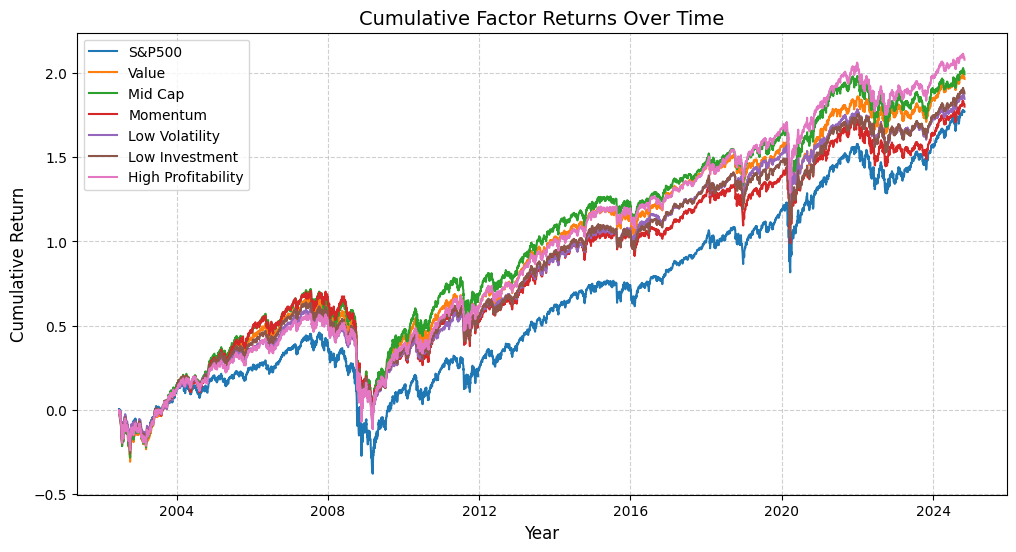

In [10]:
# Plot the cumulative product of returns
plt.figure(figsize=(12,6))  # Increase figure size
plt.plot(np.log((factor_returns + 1).cumprod()))

# Add labels and title
plt.title("Cumulative Factor Returns Over Time", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)

# Enable grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend (assuming factor_returns has column names)
plt.legend(factor_returns.columns, loc='upper left')

# Show the plot
plt.show()


In [23]:
factor_excess_returns = factor_returns["2002-01-01":"2017-01-01"].sub(factor_returns['S&P500'], axis=0)
factor_excess_returns.corr()

,S&P500,Value,Mid Cap,Momentum,Low Volatility,Low Investment,High Profitability
S&P500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Value,NaN,1.000000,0.742983,0.489466,0.564982,0.796211,0.708328
Mid Cap,NaN,0.742983,1.000000,0.622272,0.360530,0.633092,0.649678
Momentum,NaN,0.489466,0.622272,1.000000,0.384972,0.510527,0.535573
Low Volatility,NaN,0.564982,0.360530,0.384972,1.000000,0.761084,0.649200
Low Investment,NaN,0.796211,0.633092,0.510527,0.761084,1.000000,0.723932
High Profitability,NaN,0.708328,0.649678,0.535573,0.649200,0.723932,1.000000


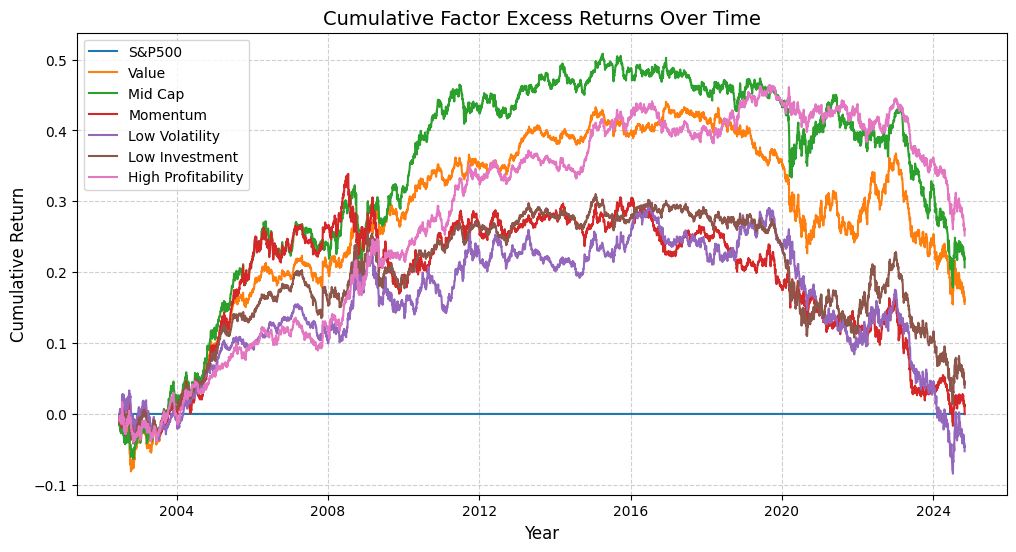

In [22]:
# Plot the cumulative product of returns
plt.figure(figsize=(12,6))  # Increase figure size
plt.plot(np.log((factor_excess_returns + 1).cumprod()))

# Add labels and title
plt.title("Cumulative Factor Excess Returns Over Time", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)

# Enable grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend (assuming factor_returns has column names)
plt.legend(factor_returns.columns, loc='upper left')

# Show the plot
plt.show()


## 2. Design parametric portfolio

In [234]:
def MVP_w(returns):
    """
    Compute the weights of the Minimum Variance Portfolio (MVP) given asset return data.

    Parameters:
    returns (pd.DataFrame): A DataFrame where each column represents the returns of a different asset.

    Returns:
    np.ndarray: A 1D array containing the optimal weights for each asset in the minimum variance portfolio.

    Description:
    - This function calculates the weights of the Minimum Variance Portfolio (MVP), which is the portfolio 
      that minimizes risk (variance) while achieving a given level of expected return.
    - It does so by solving for the weights that minimize portfolio variance using the formula:
      
      w = (V⁻¹ * μ) / (1ᵀ * V⁻¹ * μ)
      
      where:
      - V is the covariance matrix of asset returns.
      - μ is the vector of expected returns.
      - 1 is a vector of ones (to sum weights to 1).
    """
    
    ones = np.ones(len(returns.columns))
    mu = returns.mean()
    V = returns.cov()
    
    numerator = np.linalg.inv(V) @ mu
    denominator = ones.T @ numerator
    w = numerator / denominator
    return w 

def Market_w(returns):
    """
    Returns weights that are equal to 1 for market and 0 for other factors
    """
    return [1]+ (len(returns.columns)-1)*[0]

def EW_w(returns):
    """
    Equally weighted portfolio
    """
    return (len(returns.columns))*[1/len(returns.columns)]

def sharpe_ratio(returns, frequency=252, Rf=0):
    """
    Calculate the Sharpe Ratio of a given asset or portfolio.

    Parameters:
    returns (pd.Series or pd.DataFrame): A series or DataFrame of asset returns.
    frequency (int, optional): The number of trading periods in a year (default is 252 for daily returns).
    Rf (float, optional): The risk-free rate (default is 0).

    Returns:
    float or pd.Series: The Sharpe Ratio, which measures risk-adjusted return.

    Description:
    - The Sharpe Ratio evaluates the excess return per unit of risk (volatility).
    - It is calculated as:

      SR = (E[R] - Rf) / σ

      where:
      - E[R] is the expected return (mean return annualized).
      - Rf is the risk-free rate.
      - σ is the standard deviation of returns (annualized).
    - Higher values indicate better risk-adjusted performance.

    Notes:
    - If `returns` is a DataFrame, the function returns a Series of Sharpe Ratios for each asset.
    - Assumes returns are in decimal form (e.g., 0.01 for 1%).
    """
    
    mean_return = returns.mean()
    vol = returns.std()
    
    y_mean_return = mean_return * frequency
    y_vol = vol * np.sqrt(frequency)  # Fixed variable name (was 'm_vol')

    SR = (y_mean_return - Rf) / y_vol
    return SR

def sharpe_ratio_difference_test(returns_n, returns_m, sr_n, sr_m):
    """
    Computes the Jobson-Korkie-Memmel (JKM) test statistic to evaluate whether 
    the difference in Sharpe Ratios between two portfolios is statistically significant.
    
    Parameters:
    - returns_n: Daily returns of portfolio n (e.g., alternative strategy)
    - returns_m: Daily returns of portfolio m (e.g., market benchmark)
    - sr_n: Sharpe Ratio of portfolio n
    - sr_m: Sharpe Ratio of portfolio m
    - T: Number of observations (trading days)

    Returns:
    - z_stat: Z-score indicating how significant the difference in Sharpe Ratios is
    - p_value: P-value (small p-value means the difference is statistically significant)
    """
    
    T = len(returns_n) 
    
    # Compute correlation between excess returns of the two portfolios
    rho_nm = np.corrcoef(returns_n.astype(np.float32), returns_m.astype(np.float32))[0, 1]

    # Compute variance of the difference in Sharpe Ratios using the Jobson-Korkie-Memmel formula
    variance_diff = (1 / T) * (2 - 2 * rho_nm + 0.5 * (sr_n**2 + sr_m**2 - 2 * sr_n * sr_m * rho_nm**2))

    # Compute the test statistic (Z-score), which measures how different the Sharpe Ratios are
    z_stat = (sr_n - sr_m) / np.sqrt(variance_diff)

    # Compute the two-tailed p-value, which tests if the difference is statistically significant
    p_value = 2 * (1 - norm.cdf(abs(z_stat)))

    # Return the test statistic and p-value
    return p_value.round(3)


def get_first_last_dates_each_month(df):
    """
    Given a DataFrame with dates as index, this function returns a DataFrame
    containing the first and last date for each month.

    Parameters:
    df (pd.DataFrame): DataFrame with a datetime index.

    Returns:
    pd.DataFrame: A DataFrame with first and last date of each month.
    """

    # Convert index to datetime if not already
    df.index = pd.to_datetime(df.index)

    # Group by year-month and find first and last date
    first_dates = df.groupby(df.index.to_period('M')).apply(lambda x: x.index.min())
    last_dates = df.groupby(df.index.to_period('M')).apply(lambda x: x.index.max())

    # Create a DataFrame with results
    date_summary = pd.DataFrame({'First_Date': first_dates, 'Last_Date': last_dates})

    return date_summary

def find_optimal_rebalancing_weights(daily_returns, 
                                     dates_of_period_start_and_end,
                                     weight_optimization_function,
                                     est_window=120):
    """
    Computes the optimal portfolio weights for rebalancing at the start of each month 
    using a rolling estimation window of past returns.

    Parameters:
    - daily_returns (pd.DataFrame): A DataFrame containing daily return data with dates as index. 
      Monthly returns can be used too
    - dates_of_period_start_and_end (pd.DataFrame): A DataFrame containing the first and last trading 
      dates of each month, with columns ['First_Date', 'Last_Date'].
    - est_window (int): The number of months used for the estimation window (default is 120 months).

    Returns:
    - pd.DataFrame: A DataFrame where each row corresponds to the rebalancing date and contains 
      the optimal portfolio weights for that period.
    """

    # Initialize an empty DataFrame to store optimal weights at the start of each month
    weights_start_of_month = pd.DataFrame(columns=daily_returns.columns)
    
    # Iterate over each month to determine rebalancing weights
    for month_number in np.arange(est_window, dates_of_period_start_and_end.shape[0], 1):
        # Determine the start and end dates of the rolling estimation window
        start_date_of_sample = dates_of_period_start_and_end.loc[:, 'First_Date'].iloc[month_number - est_window]  # Oldest date in the estimation window
        end_date_of_sample = dates_of_period_start_and_end.loc[:, 'Last_Date'].iloc[month_number - 1]  # Last date before rebalancing

        # Extract the estimation dataset (past returns used to compute optimal weights)
        estimation_dataset = daily_returns.loc[start_date_of_sample:end_date_of_sample, :]

        
        # Compute optimal portfolio weights based on the estimation dataset
        optimal_weights = weight_optimization_function(estimation_dataset)

        
        # Determine the rebalancing date (first trading day of the current month)
        rebalancing_date = dates_of_period_start_and_end.loc[:, 'First_Date'].iloc[month_number]

        # Store the computed optimal weights for the corresponding rebalancing date
        weights_start_of_month.loc[rebalancing_date, :] = optimal_weights
    
    return weights_start_of_month


def compute_weight_drift_oos(dates_of_period_start_and_end_oos, returns_daily_oos, weights_start_of_month):
    """
    Compute the weight drift for each day in the out-of-sample (OOS) dataset by tracking how 
    portfolio weights evolve due to factor returns over time.

    Parameters:
    - dates_of_period_start_and_end_oos (pd.DataFrame): DataFrame containing 'First_Date' and 'Last_Date' for each period.
    - returns_daily_oos (pd.DataFrame): DataFrame containing daily returns of assets (factors, stocks, or other instruments).
    - weights_start_of_month (pd.DataFrame): DataFrame containing initial weights at the start of each month.

    Returns:
    - weights_end_of_month (pd.DataFrame): Drifted weights at the last date of each period.
    - weights_daily (pd.DataFrame): Drifted weights for **every single day** in the dataset.
    """

    # Initialize DataFrames to store drifted weights
    weights_end_of_month = pd.DataFrame(index=dates_of_period_start_and_end_oos["Last_Date"],
                                        columns=weights_start_of_month.columns)
    
    weights_daily = pd.DataFrame(index=returns_daily_oos.index, columns=weights_start_of_month.columns)

    # Iterate over each month to compute weight drift
    for _, row in dates_of_period_start_and_end_oos.iterrows():
        start_date, end_date = row["First_Date"], row["Last_Date"]

        # Get initial weights at the start of the month
        initial_weights = weights_start_of_month.loc[start_date]

        # Extract daily returns for the period
        monthly_returns = returns_daily_oos.loc[start_date:end_date]

        if not monthly_returns.empty:
            # Compute cumulative returns over the period
            portfolio_values = (1 + monthly_returns).cumprod()

            # Compute drifted weights for each day
            for current_date in monthly_returns.index:
                daily_values = initial_weights * portfolio_values.loc[current_date]
                weights_daily.loc[current_date] = daily_values / daily_values.sum()

            # Store drifted weights at the last date of the month
            final_values = initial_weights * portfolio_values.iloc[-1]
            weights_end_of_month.loc[end_date] = final_values / final_values.sum()
        else:
            raise ValueError(f"! Monthly returns not found for period {start_date} - {end_date}")

    return weights_end_of_month, weights_daily

The estimation window is 120 months. I apply rolling window of 120 months to find optimal weights for portfolio of factors for the next period.

In [242]:
def find_portfolio_returns(ff_factors_daily,
                           weight_optimization_function,
                           est_window = 120
                          ):

    """
    This is main function that calls all other functions 
    one by one to find optimal weight allocations,
    weight drifts and find returns
    """
    # find the first and last trading date for each month
    dates_of_period_start_and_end = get_first_last_dates_each_month(ff_factors_daily)

    # find weights for start of each month out of sample
    weights_start_of_month = find_optimal_rebalancing_weights(ff_factors_daily, 
                                                              dates_of_period_start_and_end,
                                                              weight_optimization_function = weight_optimization_function,
                                                              est_window = est_window)

    # to make all weights equal to the initial allocation
    # weights_start_of_month[:] = weights_start_of_month.iloc[0]
    
    # find all dates in the first and last trading date for each month that are out of sample
    dates_of_period_start_and_end_oos = dates_of_period_start_and_end[
            dates_of_period_start_and_end["First_Date"].isin(weights_start_of_month.index)]

    # find out of sample observations of factor returns
    ff_factors_daily_oos = ff_factors_daily.loc[weights_start_of_month.index[0]:,:]
    
    # within each First_Date and each Last_Date the weights drift. Hence, one needs 
    # to find cumulative return between each of those dates to find the actual weights
    # this will allow to find actual returns of the portfolio
    # and this will allow also to account for transaction costs correctly, because difference 
    # between last date of the month weight and first date of the month weight is the actual transaction cost
    
    weights_end_of_month, weights_daily = compute_weight_drift_oos(dates_of_period_start_and_end_oos,
                                                                   ff_factors_daily_oos, 
                                                                   weights_start_of_month)
    
    portfolio_return_oos = np.sum(weights_daily*ff_factors_daily_oos, axis = 1)
    
    # some tresholds on daily returns, because some models may go wrong
    portfolio_return_oos[portfolio_return_oos>0.3] = 0.3
    portfolio_return_oos[portfolio_return_oos<-0.3] = -0.3
    
    return portfolio_return_oos, weights_start_of_month, weights_end_of_month, weights_daily

In [243]:
market_portfolio,_,_, weights_daily_mkt = find_portfolio_returns(factor_returns,
                                           Market_w,
                                           est_window = 120
                                          )

In [247]:
mpv_portfolio,_,_, weights_daily_mvp = find_portfolio_returns(factor_returns,
                                           MVP_w,
                                           est_window = 120
                                          )

In [248]:
ew_portfolio,_,_, weights_daily_mvp = find_portfolio_returns(factor_returns,
                                           EW_w,
                                           est_window = 120
                                          )

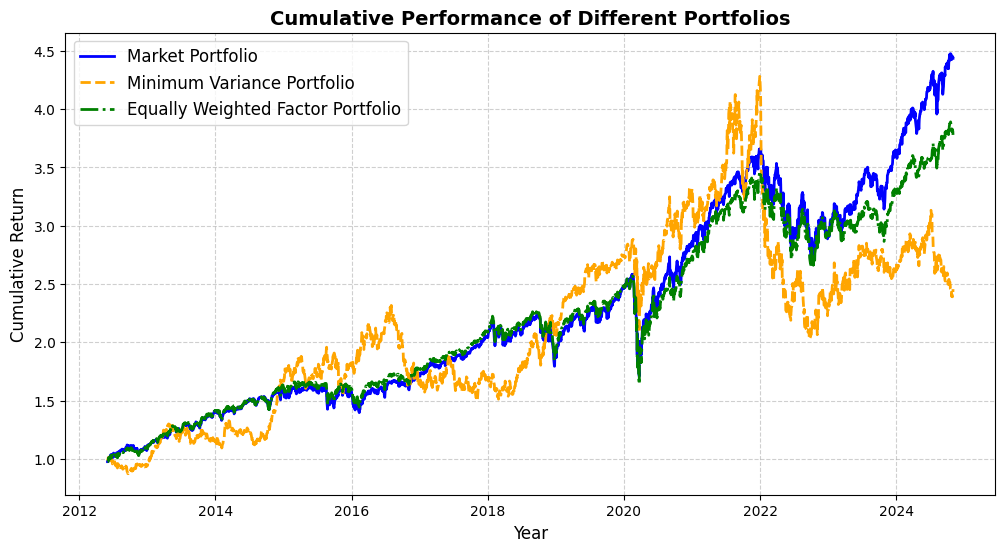

In [249]:
# Assuming market_portfolio, mpv_portfolio, and ew_portfolio are already defined Pandas Series

# Create a figure with increased size for better readability
plt.figure(figsize=(12, 6))

# Plot cumulative returns for each portfolio
plt.plot((1 + market_portfolio).cumprod(), label="Market Portfolio", linewidth=2, linestyle='-', color='blue')
plt.plot((1 + mpv_portfolio).cumprod(), label="Minimum Variance Portfolio", linewidth=2, linestyle='--', color='orange')
plt.plot((1 + ew_portfolio).cumprod(), label="Equally Weighted Factor Portfolio", linewidth=2, linestyle='-.', color='green')

# Add title and labels
plt.title("Cumulative Performance of Different Portfolios", fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc="upper left")

# Show the plot
plt.show()

To add:

- volatility-managed factors
- more factors
- SR test
- find out why portfolio is so bad performing $weights = \alpha_k +\beta_k*1/\sigma_t$ where alpha and beta do not depend on time?

In [250]:
# Calculate Sharpe Ratios for each portfolio
sharpe_ratios = {
    "Market Portfolio": sharpe_ratio(market_portfolio),
    "Minimum Variance Portfolio": sharpe_ratio(mpv_portfolio),
    "Equally Weighted Factor Portfolio": sharpe_ratio(ew_portfolio)
}

# Convert results into a DataFrame
sharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=["Sharpe Ratio"])

sharpe_df.loc['Minimum Variance Portfolio', 'p-value vs mkt'] = sharpe_ratio_difference_test(mpv_portfolio,
                                                                                                  market_portfolio,
                                                                                                  sharpe_ratio(mpv_portfolio),
                                                                                                  sharpe_ratio(market_portfolio))

sharpe_df.loc['Equally Weighted Factor Portfolio', 'p-value vs mkt'] = sharpe_ratio_difference_test(ew_portfolio, 
                                                                                                         market_portfolio,
                                                                                                         sharpe_ratio(ew_portfolio), 
                                                                                                         sharpe_ratio(market_portfolio))

sharpe_df

,Sharpe Ratio,p-value vs mkt
Market Portfolio,0.785613,NaN
Minimum Variance Portfolio,0.417148,0.0
Equally Weighted Factor Portfolio,0.730680,0.0
